# Introduction
PyMCEF construct the efficient frontier from given jointly simulated asset returns. 
With risk meausre absolute semideviation and fixed target under-performance, the optimizatoin can be reformulated as an Linear Programming problem. 
With one single optimization, PyMCEF can find all optimal solutions with risk tolerance $\lambda\in [0,\infty)$, and each optimal solution corresponds with an interval of $\lambda$.
The correctness of each optimal portfolio and its corresponding interval of $\lambda$ can be checked against existing Linear Programming softwares.

The accuracy of PyMCEF is benchmarked against [GLPK](https://www.gnu.org/software/glpk/) through python interface [cvxopt](http://cvxopt.org/).
The speed of PyMCEF is compared with both GLPK and [CLP](https://projects.coin-or.org/Clp) (through its python interface [CyLP](https://github.com/coin-or/CyLP)).

### Linear Programming Setup 

Let's denote the random returns of all $N$ assets as a vector Y.
A portfolio is defined by the $N$-vector of weights $\{w_n\}_{n=1}^N$.
The reward of a portfolio is defined as its expected return.

$$E[Y^{T}w]=E[\sum_{n=1}^{N}w_{n}Y_{n}]$$

Consider $K$ samples of $Y$: $\{Y^{k}\}_{k=1}^{K}$ and their sample
means:
\begin{eqnarray*}
\overline{Y}_{n} & = & \frac{1}{K}\sum_{k=1}^{K}Y_{n}^{k},\\
\overline{Y} & = & \left[\overline{Y}_{1},\dots,\overline{Y}_{n}\right]^{T}.
\end{eqnarray*}

Wtih absolute semideviation as risk measure, the optmization becomes the following:

\begin{eqnarray}
\underset{{u_{k},w_{n},v_{k}}}{\mathrm{argmin}} & \frac{1}{K}\sum_{k=1}^{K}u_{k}-\lambda\sum_{n=1}^{N}w_{n}\overline{Y}_{n}\\
\mathrm{subject\ to} & \sum_{n=1}^{N}w_{n} & =1\\
& u_{k}+\sum_{n=1}^{N}w_{n}(Y_{n}^{k}-\overline{Y}_{n})-v_{k} & =0\quad \forall k=1,\dots,K \\
 & w_{n},u_{k},v_{k} & \ge0.
\end{eqnarray}

With fixed target under-performance as risk measure, 
the optimization becomes the following:

\begin{eqnarray}
\underset{{u_{k},w_{n},v_{k}}}{\mathrm{argmin}} & \frac{1}{K}\sum_{k=1}^{K}u_{k}-\lambda\sum_{n=1}^{N}w_{n}\overline{Y}_{n}\\
\mathrm{subject\ to} & \sum_{n=1}^{N}w_{n} & =1\\
 & u_{k}+\sum_{n=1}^{N}w_{n}Y_{n}^{k}-v_{k} & =t\quad \forall k=1,\dots,K \\
 & w_{n},u_{k},v_{k} & \ge0,
\end{eqnarray}
where $t$ is the target, and $u_k$ are auxilary variables and $v_k$ are slack variables. 

# Benchmark Problems

We start with a small starter problem where the details of LP problem and the optimal solutions can be displayed. 
After that, we test with larger problem to compare the results of PyMCEF and GLPK.

### Starter problem

Consider an investment universe with 3 assets, whose cross sectional returns have 3 equally possible outcomes:

|           | Asset 1 | Asset 2 | Asset 3 |
|-----------|---------|---------|---------|
| Outcome 1 | 10      | 1       | 5       |
| Outcome 2 | -2      | 0       | 2      |
| Outcome 3 | -3      | 1       | -3      |
We use the fixed-target under-performance as risk measure and choose the fixed-target as $t=0$.
In this case, the linear programming problem is:

\begin{align*}
\underset{\mathrm{u_{1},u_{2},u_{3},w_{1},w_{2},w_{3},v_{1},v_{2},v_{3}\ge0}}{\mathrm{argmin}} & \frac{1}{3}u_{1}+\frac{1}{3}u_{2}+\frac{1}{3}u_{3}-\lambda\left(\frac{5}{3}w_{1}+\frac{2}{3}w_{2}+\frac{1}{3}w_{3}\right)\\
\left[\begin{array}{ccccccccc}
0 & 0 & 0 & 1 & 1 & 1 & 0 & 0 & 0\\
1 &  &  & 10 & 1 & 5 & -1\\
 & 1 &  & -2 & 0 & 2 &  & -1\\
 &  & 1 & -3 & 1 & -3 &  &  & -1
\end{array}\right] & \left[\begin{array}{c}
u_{1}\\
u_{2}\\
u_{3}\\
w_{1}\\
w_{2}\\
w_{3}\\
v_{1}\\
v_{2}\\
v_{3}
\end{array}\right]=\left[\begin{array}{c}
1\\
0\\
0\\
0
\end{array}\right]
\end{align*}

With PyMCEF we can obtain all the optimal solutions, with $\lambda$ varying from $+\infty$ to $0$.

In [1]:
%%capture
from pymcef import SimpleEF, RiskMeasure
import numpy as np
# notice that each row corresponds of all realizations of one asset return

returns = np.array([10,-2,-3,1,0,1,5,2,-3]).reshape((3, 3))
labels = ['Asset 1', 'Asset 2', 'Asset 3']
sol = SimpleEF(training_set = returns, \
               risk_measure = RiskMeasure.FixTargetUnderPerformance, 
               target_return = 0,\
               asset_names = labels)

The solutions are:

In [2]:
i = 1
for prt in sol.frontier_in_sample:
    print("Efficient portfolio: " + str(i))
    lbd_l, lbd_u = prt['lambda_l'], prt['lambda_u']
    print("  Risk tolerance interval: (" + str(lbd_l) + ", " + str(lbd_u) + ")")
    ws = prt['weight']
    ks = [labels[i] for i in ws.keys()]
    vs = [str(v) for v in  ws.values()]
    print("  Positions: ")
    print("    " + ", ".join(ks))
    print("    " + ", ".join(vs))
    i += 1
#sol.frontier_in_sample[0]

Efficient portfolio: 1
  Risk tolerance interval: (4.0, inf)
  Positions: 
    Asset 1
    1.0
Efficient portfolio: 1
  Risk tolerance interval: (1.6, 4.0)
  Positions: 
    Asset 1, Asset 3
    0.5, 0.5
Efficient portfolio: 3
  Risk tolerance interval: (0.0, 1.6)
  Positions: 
    Asset 1, Asset 2, Asset 3
    0.125, 0.75, 0.125


Now we choose various risk tolerances and use cvxopt(GLPK) to obtain the optimal solutions. 
Each solution obtained by cvxop should agree with one of the three solutions produced by PyMCEF, whose interval of $\lambda$ covers that particular risk tolerance used by cvxop.

In [3]:
from cvxopt import solvers, matrix
solvers.options['show_progress'] = False

def Solve_With_GLPK(returns, lbds, t):
    numSims = returns.shape[0]
    numAssets = returns.shape[1]
    idn = np.eye(numSims)
    A_ub = - np.hstack((idn, returns)) # <= -t
    b_ub = np.array([-t]*numSims)
    c0 = returns.mean(axis=0)
    c1 = np.array([1.0/numSims] * numSims)
    A_eq = np.matrix([0.0]*numSims + [1.0] * numAssets)
    b_eq = np.array([1.0])

    G = matrix(np.vstack((A_ub, -np.eye(numSims + numAssets))))
    h = matrix([-t]*numSims + [0.0] * (numSims + numAssets))
    A = matrix([0.0]*numSims + [1.0] * numAssets, (1, numSims + numAssets))
    b = matrix([1.0])
    weights_cvxopt = np.zeros((len(lbds), numAssets))
    for i in range(len(lbds)):
        lbd = lbds[i]
        c = matrix(np.hstack((c1, -lbd * c0)))
        sol_cvxopt = solvers.lp(c, G, h, A=A, b=b, solver='glpk')
        tmp = np.array(sol_cvxopt['x'][-3:])
        weights_cvxopt[i, :] = tmp[:, 0]
    return weights_cvxopt

In [4]:
from IPython.display import HTML, display
import tabulate
lambdas = np.linspace(5.0, 0.0, 11)
weights = Solve_With_GLPK(returns.T, lambdas, 0)
output = [['Risk tolerance'] + labels]
for lbd, ws in zip(lambdas, weights):
    output.append([lbd] + ws.tolist())
display(HTML(tabulate.tabulate(output, tablefmt='html')))

Risk tolerance,Asset 1,Asset 2,Asset 3
5.0,1.0,0.0,0.0
4.5,1.0,0.0,0.0
4.0,0.5,0.0,0.5
3.5,0.5,0.0,0.5
3.0,0.5,0.0,0.5
2.5,0.5,0.0,0.5
2.0,0.5,0.0,0.5
1.5,0.125,0.75,0.125
1.0,0.125,0.75,0.125
0.5,0.125,0.75,0.125


As can be shown from the results displayed above, GLPK validates PyMCEF on this starter problem.
Notice that without PyMCEF, you have no knowledge of those intervals, all you can do is to try your luck with many different values of $\lambda$, 
and hope that the solutions you obtain will cover the part of efficient frontier that you are interested.

### Heavy-duty problem

Now let's use Monte Carlo to simulate a return distribution with a large number of realizations.
We will validate the results obtained by PyMCEF by GLPK and compare their speed.

We use a 3D normal distribution with the following covariance matrix and mean.


\begin{align*}
\mu=\left[\begin{array}{c}
5\\
2\\
4
\end{array}\right], & \Sigma=\left[\begin{array}{ccc}
10 & -3 & -1\\
-3 & 2 & 1\\
-1 & 1 & 4
\end{array}\right].
\end{align*}

The fixed target is chosen as $t=2$ in the risk measure. First let's solve with PyMCEF:

In [5]:
from numpy.random import multivariate_normal as mn
from time import time
numSims = 1000 # Typical Monte Carlo simulation usually have 100 times more paths
t = 2
means = [5, 2, 4]
covs = [[10, -3, -1],
        [-3, 2, 1], 
        [-1, 1, 4]] 
returns = mn(means, covs, numSims)

tic = time()
simple_ef = SimpleEF(target_return=t, training_set=returns.T,
                     risk_measure=RiskMeasure.FixTargetUnderPerformance)
cost_pymcef = time() - tic 
ports = simple_ef.frontier_in_sample
weights_pymcef = np.zeros((len(ports), 3))
lbds = []
for i in range(len(ports)):
    ws = ports[i]['weight']
    lbd_l = ports[i]['lambda_l']
    lbd_u = ports[i]['lambda_u']
    lbds.append((lbd_l + lbd_u)/2.0 if i > 0 else 2.0*lbd_l)
    for k, v in ws.items():
        weights_pymcef[i][k] = v
print("Total time cost for PyMCEF: " + str(cost_pymcef) + " s")

Total time cost for PyMCEF: 0.00790500640869 s


Then we solve it with GLPK:

In [6]:
tic = time()
weights_glpk = Solve_With_GLPK(returns, lbds, t)
cost_glpk = time() - tic
print("Total time cost for GLPK: " + str(cost_glpk) + " s")

Total time cost for GLPK: 32.6528289318 s


As we can see, for this particular problem, PyMCEF is orders of magnitude faster than GLPK. And the solutions obtained by these two methods agree up to machine epsilon.

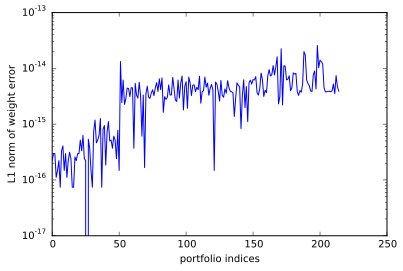

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
diffs = np.mean(np.abs(weights_pymcef - weights_glpk), axis=1)
plt.plot(diffs)
plt.yscale('log')
plt.xlabel('portfolio indices')
plt.ylabel('L1 norm of weight error')

We can conclude that the correctness and accuracy of PyMCEF is successfully validated by GLPK.

## More on speed

[CLP](https://projects.coin-or.org/Clp) is another open source linear programming library, which is [faster](http://plato.asu.edu/ftp/lpsimp.html) than GLPK. 
We would like to compare the time costs of all the three packages, on the above problem with increasing number of simulated returns.

CyLP can use inequality constraints, let's reformulate the problem:

\begin{eqnarray*}
\min_{u_{k},w_{n},v_{k}} & \frac{1}{K}\sum_{k=1}^{K}u_{k}-\lambda\sum_{n=1}^{N}w_{n}\overline{Y}_{n}\\
\mathrm{subject\ to} & \sum_{n=1}^{N}w_{n} & =1\\
 & u_{k}+\sum_{n=1}^{N}w_{n}Y_{n}^{k} & \ge t\\
 & w_{n},u_{k} & \ge0.
\end{eqnarray*}

Let's set up CLP to solve this problem.

In [8]:
# prepare CLP solver via CyLP 
import warnings
warnings.filterwarnings('ignore')
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray
def Solve_With_CLP(returns, lbds, t):
    numSims = returns.shape[0]
    numAssets = returns.shape[1]
    smplx = CyClpSimplex()

    # Add variables
    w = smplx.addVariable('w', numAssets)
    u = smplx.addVariable('u', numSims)
    A = np.matrix(returns)
    B = np.matrix(np.eye(numSims, dtype='float64'))
    b = CyLPArray([t] * numSims)

    # Add constraints
    smplx += B * u + A * w >= b
    smplx += w.sum() == 1.0
    smplx += w >= 0.0
    smplx += u >= 0.0
    # Set the objective function
    c = CyLPArray(returns.mean(axis=0))
    c2 = CyLPArray([1.0/numSims] * numSims)

    # Solve the LP problems
    weights_clp = np.zeros((len(lbds), numAssets))
    for i in range(len(lbds)):
        lbd = lbds[i]
        c1 = lbd * c
        smplx.objective = c2 * u -  c1 * w
        smplx.primal()
        weights_clp[i,:]=smplx.primalVariableSolution['w'] 
    return weights_clp

Use all three packages to solve for more and more costy problem:

In [9]:
Sims_all = [100*2**i for i in range(6)]
costs_clp = np.zeros(len(Sims_all))
costs_glkp = np.zeros(len(Sims_all))
costs_pymcef = np.zeros(len(Sims_all))

In [10]:
for j in range(len(Sims_all)):
    numSims = Sims_all[j]
    returns = mn(means, covs, numSims)

    # using PyMCEF
    tic = time()
    simple_ef = SimpleEF(target_return=t, training_set=returns.T,
                         risk_measure=RiskMeasure.FixTargetUnderPerformance)
    ports = simple_ef.frontier_in_sample
    weights_pymcef = np.zeros((len(ports), 3))
    lbds = []
    for i in range(len(ports)):
        ws = ports[i]['weight']
        lbd_l = ports[i]['lambda_l']
        lbd_u = ports[i]['lambda_u']
        lbds.append((lbd_l + lbd_u)/2.0 if i > 0 else 2.0*lbd_l)
        for k, v in ws.items():
            weights_pymcef[i][k] = v
    costs_pymcef[j] = time() - tic
   
    # using GlPK
    tic = time()
    weights_glpk = Solve_With_GLPK(returns, lbds, t)
    costs_glkp[j] = time() - tic
    
    #using ClP
    tic = time()
    weights_clp = Solve_With_CLP(returns, lbds, t)
    costs_clp[j] = time() - tic

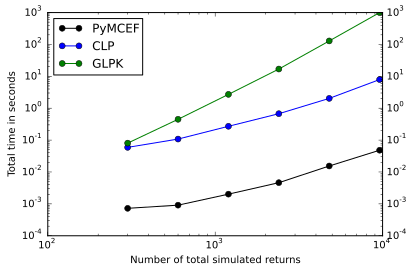

In [11]:
numTotalReturns = len(means) * np.array(Sims_all)
plt.xscale('log')
plt.yscale('log')
plt.plot(numTotalReturns, costs_pymcef, 'k-o',label='PyMCEF')
plt.plot(numTotalReturns, costs_clp, 'b-o',label='CLP')
plt.plot(numTotalReturns, costs_glkp, 'g-o',label='GLPK')
plt.xlabel('Number of total simulated returns')
plt.ylabel('Total time in seconds')
plt.tick_params(axis='y', right='on', labelright='on')
plt.legend(loc='upper left')
plt.savefig('output/performance.png')

The difference demonstrated by the above plot shows that PyMCEF is the only package making it practical to construct efficient frontier from Mote Carlo simulated returns.